# Data Generator Interval Analysis

This notebook reads the data generated by the data generator program and both sanity check it and post process it to generate BSP interval lengths that can be analyzed to understand and/or prediction application behavior.

## Time Breakdown of a Sample interval
We first read in the data we're analyzing and compute the important derived values, namely the length of the interval on each rank and the amount of time waited on each rank, and the expected and actual interval lengths for each interval. 

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import genextreme
from scipy import stats
import scipy.special
# 
rankdata = pd.read_csv('../results/result.csv').sort_values(['uniq_id', 'iteration', 'rank'])

# First compute the interval lengths and subdivisions themselves - we have expected/actual sleep_nsec,
# so we need wait_nsec and interval_nsec just to make things easier.

rankdata['wait_nsec'] = rankdata.apply(lambda row: row.barrier_end - row.barrier_start, axis = 1)
rankdata['interval_nsec'] = rankdata.apply(lambda row: row.barrier_end - row.sleep_start, axis = 1)
    
# Show an example iteration
# i=5
# rankdata[rankdata['iteration']==i][['rank', 'actual_sleep_nsec', 'wait_nsec']].plot.barh(x=0,stacked=True).set_ylabel('rank')
# plt.show()

# Next we create a dataframe for the rank-wide per-iteration data of all experiments
# To do this, we just copy the rank 0 data in the original data frame and rename appropriate
# columns
iterdata = rankdata[rankdata['rank'] == 0].copy().reset_index(drop=True)
iterdata = iterdata.rename(columns={'rank':'ranks', 
                                    'interval_nsec':'actual_interval_max', 
                                    'expected_sleep_nsec':'expected_interval_max'})
iterdata = iterdata.drop(['wait_nsec', 'sleep_start', 'barrier_start', 'barrier_end', 'actual_sleep_nsec'] , axis=1)

# Now go through the original data and compute summary statistics for each interval
for frame in rankdata.groupby(['uniq_id', 'iteration']):
    ranks = len(frame[1])
    emax = frame[1]['expected_sleep_nsec'].max()
    amax = frame[1]['interval_nsec'].max()
    qlist = (iterdata['uniq_id'] == frame[0][0]) & (iterdata['iteration'] == frame[0][1])
    iterdata.loc[qlist, ['ranks', 'expected_interval_max', 'actual_interval_max']] = ranks, emax, amax

## Sanity Check the Data from the Data Generator

The data generator program does a lot of things that *could* skew the statistics we're going to work with, so the first thing we're going to do is sanity check its data. In particular, we check that:
  1. The random samples the data generator uses for determining how long to sleep are drawn from the distribution it claims they're supposed to be drawn from and aren't skewed by random number generation or filtering, and
  1. The actual times that the data generator sleeps on each node are from the same distribution as the expected times to be slept, that is that our sleep mechanism isn't siginficantly skewing our numbers.

In [197]:
# For each experiment we're processing:
for frame in rankdata.groupby(['uniq_id']):
# First test that the the parallel random number generator in the
# data generator by looking at the running expected waits

# Get the distribution that the data generator used
    distribution=df['distribution'][0]
    distmap = { 'gaussian':'norm', 'exponential':'expon', 'uniform':'uniform', 'pareto':'pareto'}
    scipydist = distmap[distribution]
    a = frame[1]['mean'].iloc[0]*1000
    b = frame[1]['std'].iloc[0]*1000

    # First, are the full set of samples distributed as per requested
    # the requested distribution, or is the data generator doing something
    # that's skewing the data? For example, the data generator cuts off sleep times
    # less than 0. If values less than zero would normally be a significant 
    # portion of the distribution, for example gaussian with mean and standard 
    # deviation near each other, this test could fail.
    confidence = 0.05
    (statistic, pvalue) = stats.kstest(frame[1]['expected_sleep_nsec'].ravel(), scipydist, (a, b))
    if (pvalue < confidence):
        print('ERROR: Rejecting null hypothesis in experiment {0} that\n'.format(frame[0]), 
              'expected sleep values came from {0} ({1}, {2}) with p={3} < {4}'.format(distribution, a, b, pvalue, confidence))
    else:
        print('Expected sleep values in experiment {0}\n'.format(frame[0]),
              'came from {0} ({1}, {2}) with p={3} > {4}'.format(distribution, a, b, pvalue, confidence))

    # Next, test for the actual sleep values versus the expected sleep values. These
    # skew slightly larger than the expected sleep values do to experimental problems so this
    # test could fail particulalry for short wait times where this error is relatively 
    # significant.
    (statistic, pvalue) = stats.ks_2samp(frame[1]['expected_sleep_nsec'].ravel(), frame[1]['actual_sleep_nsec'].ravel())
    if (pvalue < confidence):
        print('ERROR: Rejecting null hypothesis in experiment {0} that actual sleep values\n'.format(frame[0]),
             'come from same distribution as expected sleep values with p={0} < {1}'.format(pvalue, confidence))
    else:
        print('Actual and expected sleep values in experiment {0}\n'.format(frame[0]),
              'come from same distribution with p={0} > {1}'.format(pvalue, confidence))

Expected sleep values in experiment 1785361834be5
 came from gaussian (100000000.0, 10000000.0) with p=0.6320835187923194 > 0.05
Actual and expected sleep values in experiment 1785361834be5
 come from same distribution with p=1.0 > 0.05
Expected sleep values in experiment 2bbe44d57b4a0
 came from gaussian (100000000.0, 10000000.0) with p=0.5392584985057203 > 0.05
Actual and expected sleep values in experiment 2bbe44d57b4a0
 come from same distribution with p=1.0 > 0.05
Expected sleep values in experiment 2bee7145de0f1
 came from gaussian (100000000.0, 10000000.0) with p=0.4914836525704639 > 0.05
Actual and expected sleep values in experiment 2bee7145de0f1
 come from same distribution with p=1.0 > 0.05
Expected sleep values in experiment a13d3a6fe429f
 came from gaussian (100000000.0, 10000000.0) with p=0.8548059098715622 > 0.05
Actual and expected sleep values in experiment a13d3a6fe429f
 come from same distribution with p=1.0 > 0.05
Expected sleep values in experiment f1ec7d2f4e3ea
 c

# Compute and Sanity Check Interval GEV distributions
We now start analyzing the maximums in the data generator data. This includes some basic sanity checking 
that we're actually analyzing maximums from the expected data, but also starts checking assumptions
that the system on which we're running behaves in certain ways. that e maximums of the expected times, finally, should fit a GEV distribution since they're literlly maximums of samples from the distributions we just checked above. We verify this basic GEV assumption.

In [199]:
# We also want to check information on the maxima, which is harder since GEV estimation is tricky. 
# We use an alternative method for this estimation from XXX to attempt this that Chris Leap implemented
def moment(xs, moment):
    samples = np.sort(xs)
    n = samples.size
    res = 0
    for j, sample in enumerate(samples):
        term = sample
        for i in range(1,moment + 1):
            term = term * (j + 1 - i) / (n - i)
        res = res + term
    return res / n

def pwm_params(samples):
    # Generate moments from sample data
    samples = np.sort(samples)
    n = samples.size
    b0 = moment(samples,0)
    b1 = moment(samples,1)
    b2 = moment(samples,2)

    # Generate GEV parameters
    c = (2*b1-b0)/(3*b2-b0) - np.log(2)/np.log(3)
    est_shape = 7.8590*c+2.9554*np.power(c,2)
    gamma = scipy.special.gamma(1 + est_shape)
    est_scale = est_shape*(2*b1-b0)/(gamma*(1-np.power(2,-est_shape)))
    est_loc = b0 + est_scale*(gamma-1)/est_shape
    return est_shape,est_loc,est_scale

# First create a table to hold per-experiment data
expdata = iterdata[iterdata['iteration'] == 0].copy().reset_index(drop=True)
expdata = expdata.drop(['iteration', 'actual_interval_max', 'expected_interval_max'], axis=1)

# Compute the runtime of the experiment and the GEV parameters of the expected interval
# lengths 
expdata['runtime'] =\
    expdata.apply(lambda row: iterdata[iterdata['uniq_id'] \
                                       == row.uniq_id].actual_interval_max.sum(),
                  axis = 1)
expdata['expected_gev'] = \
    expdata.apply(lambda row: pwm_params(iterdata[iterdata['uniq_id'] \
                                                  == row.uniq_id].expected_interval_max),
                  axis = 1)

# Next check how well each fits of the expected data in question. We intentionall
# don't do a goodness of fit of the actuals here 
for frame in iterdata.groupby('uniq_id'):
    # the expected maximums should be distributed as per an extreme value distribution, since
    # they are the maximas of the distributions above
    eparam = expdata[expdata['uniq_id'] == frame[0]].expected_gev.array[0]
    statistic, pvalue = stats.kstest(frame[1].expected_interval_max, 'genextreme', args = eparam)
    if (pvalue < confidence):
        print('ERROR: Rejecting NULL Hypothesis that expected interval lengths fit\n',
              'GEV {0} with p={1} < {2}'.format(eparam, pvalue, confidence))
    else:
        print('Expected interval lengths come from GEV {0}\n'.format(eparam),
              'with p={0} > {1}'.format(pvalue, confidence))

Expected interval lengths come from GEV (0.11067492263544816, 118769836.41103855, 4377692.089595852)
 with p=0.9812583438149987 > 0.05
Expected interval lengths come from GEV (0.15108105413805492, 115406877.60080239, 4948660.204494952)
 with p=0.962189378920589 > 0.05
Expected interval lengths come from GEV (0.21075267794004368, 112156545.19366091, 5900216.471755702)
 with p=0.720562302245759 > 0.05
Expected interval lengths come from GEV (0.11936829908551252, 124398745.56424873, 3666786.7186942305)
 with p=0.9822566079857046 > 0.05
Expected interval lengths come from GEV (0.11441900363601773, 121695794.10010889, 4039719.708568653)
 with p=0.9525469987137503 > 0.05


## Analyze the Actual Maximums

Now that we know that the basic data generator data is sane, we're going to start analyzing the actual maxima of intervals. These can be perturbed by the underlying system hardware (for example the system software on each node and the network which runs the barriers). As a result, we first check if the actual lengths are GEV distributed, and then of they come from the same distribution as the expected lengths. They may not if the system on which we're running has a lot of noise, and that's not necessarily bad but is worth noting if so.

In [202]:
# Like above, we compute GEV estimates for the actual maximums. However, while things are erroneous
# if the expected values don't fit a GEV, the actual values not fitting a GEV is not 
# necessarily an error and can indicate that the system we're analyzing is doing something
# interesting.
expdata['actual_gev'] = \
    expdata.apply( lambda row: pwm_params(iterdata[iterdata['uniq_id'] == row.uniq_id].actual_interval_max),
                   axis = 1)

# Next check how well each fits of the expected data in question. We intentionall
# don't do a goodness of fit of the actuals here 
for frame in iterdata.groupby('uniq_id'):
    # Many of our analysis assume actual maximums should be distributed as per an extreme
    # value distribution, but there could be cases this isn't true. Check.
    aparam = expdata[expdata['uniq_id'] == frame[0]].actual_gev.array[0]
    statistic, pvalue = stats.kstest(frame[1].expected_interval_max, 'genextreme', args = aparam)
    if (pvalue < confidence):
        print('WARNING: Rejecting null hypothesis that actual interval lengths fit\n',
              'GEV {0} with p={1} < {2}'.format(aparam, pvalue, confidence))
    else:
        print('Actual interval lengths come from GEV {0}\n'.format(aparam),
              'with p={0} > {1}'.format(pvalue, confidence))
    
    # We may have gotten different parameters for hte fits of the samples, but check statistically
    # if they'er plausibly come from the same distribution as the expected maxima? 
    (statistic, pvalue) = stats.ks_2samp(frame[1].expected_interval_max, frame[1].actual_interval_max)
    if (pvalue < confidence):
        print('WARNING: Rejecting null hypothesis that expected maxes come from\n',
              'same distribution as actual maxes with p=%f < %f' % (pvalue, confidence))
    else:
        print('Actual and expected interval lengths come from same distribution\n',
              'with p={0} > {1}'.format(pvalue, confidence))

Actual interval lengths come from GEV (0.10933799176697025, 118800270.80356391, 4381154.973975314)
 with p=0.9857047305576017 > 0.05
Actual and expected interval lengths come from same distribution
 with p=0.9999999999993714 > 0.05
Actual interval lengths come from GEV (0.15108840691918243, 115427648.70473409, 4951124.127809838)
 with p=0.9295004222017706 > 0.05
Actual and expected interval lengths come from same distribution
 with p=0.9999999999999997 > 0.05
Actual interval lengths come from GEV (0.21075399312852858, 112167467.3081668, 5900849.948237321)
 with p=0.6873146389930898 > 0.05
Actual and expected interval lengths come from same distribution
 with p=1.0 > 0.05
Actual interval lengths come from GEV (0.11987574187197024, 124444796.00683935, 3670812.016758914)
 with p=0.9443885750003878 > 0.05
Actual and expected interval lengths come from same distribution
 with p=0.999999678182 > 0.05
Actual interval lengths come from GEV (0.11392832562469335, 121726597.65711908, 4047185.7650

## Project Scaling of Intervals
Our approach uses the EMMA approximation to project runtimes at larger scales. This is similar to the traditional extreme value "return level" approach, but the return level is a value that will be exceeded, not a maximum so it doesn't do what we need to do. Instead, combining the GEV block maxima method and the EMMA approach for computing the expected mean maximum (note its similarity to the return level formula below) ended up being the key to predicting BSP application runtime.

For each set of parameters (distribution, iterations) the code below uses the GEV fit from the smallest number of ranks to project the runtime for the same parameters on larger numbers of cores and plots that versus the actual runtimes on larger numbers of cores. 

Projecting runtimes for experiment ('gaussian', 100000.0, 10000.0, 1000)


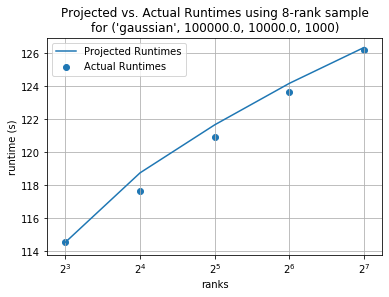

In [206]:
def return_level(dist, p):
    return dist.ppf(1-1/p)

def emma(dist, p):
    return dist.ppf((0.570376002)**(1/p))
    
def project_runtimes(exp, row, fig, ax):
    iterations = row['iterations']
    ranks = [row['ranks']]
    aparam = row['actual_gev']
    gevdist = stats.genextreme(*aparam)

    # Our runtime on 1 block is just the expected value of the distribution
    runtime_emma = [gevdist.moment(1)*iterations/1000000000]

    for i in range(1, 5):
        ranks.append(row['ranks']*(2**i))
        runtime_emma.append(emma(gevdist, 2**i)*iterations/1000000000)

    ax.plot(ranks, runtime_emma, label='Projected Runtimes'.format(ranks[0]))
    ax.set_xscale('log', basex=2)
    ax.set(xlabel='ranks', ylabel='runtime (s)', xticks=ranks,
           title='Projected vs. Actual Runtimes using {0}-rank sample\nfor {1}'.format(ranks[0],exp))

# For each set of distributions and parameters, project runtimes from smallest
# experiment and plot larger experiments versus this projection
for frame in expdata.groupby(['distribution', 'mean', 'std', 'iterations']):
    exps = frame[1].sort_values(['ranks']).reset_index(drop=True)
    print('Projecting runtimes for experiment {0}'.format(frame[0]))

    fig, ax = plt.subplots()
    runtimes = []
    sizes = []
    for iter, row in exps.iterrows():
        sizes.append(row['ranks'])
        runtimes.append(row['runtime']/1000000000)
        if iter == 0:
            project_runtimes(frame[0], row, fig, ax)
    ax.scatter(sizes, runtimes, label='Actual Runtimes')
    ax.grid()
    plt.legend()
    plt.show()